# Learning to Predict by the Methods of Temporal Differences

## Background

### Theory
observation-outcome sequence: $x_1, x_2, x_3, \ldots, x_m, z$

Prediction: $P\left(x_t, w\right)$

for each sequence, produce prediction $P_1, P_2, P_3, \ldots, P_m$

Update:

$$w \leftarrow w+\sum_{t=1}^m \Delta w_t$$

$\mathrm{TD(1)}$:

$z-P_t=\sum_{k=t}^m\left(P_{k+1}-P_k\right) \quad$ where $\quad P_{m+1} \stackrel{\text { def }}{=} z$

therefore

$$\begin{aligned} w \leftarrow w+\sum_{t=1}^m \alpha\left(z-P_t\right) \nabla_w P_t & =w+\sum_{t=1}^m \alpha \sum_{k=t}^m\left(P_{k+1}-P_k\right) \nabla_w P_t \\ & =w+\sum_{k=1}^m \alpha \sum_{t=1}^k\left(P_{k+1}-P_k\right) \nabla_w P_t \\ & =w+\sum_{t=1}^m \alpha\left(P_{t+1}-P_t\right) \sum_{k=1}^t \nabla_w P_k\end{aligned}$$

or:

$$\Delta w_t=\alpha\left(P_{t+1}-P_t\right) \sum_{k=1}^t \nabla_w P_k$$

$\mathrm{TD(\lambda)}$:

Consider an exponential decayed weighting with recency:

$$\Delta w_t=\alpha\left(P_{t+1}-P_t\right) \sum_{k=1}^t \lambda^{t-k} \nabla_w P_k$$

def: $\quad e_t$ = $\sum_{k=1}^t \lambda^{t-k} \nabla_w P_k$

then: $\quad e_{t+1} = \lambda e_t + \nabla_w P_{t+1}$

### Bounded Random Walk
All walks begin in state $D$. From states $B$, $C, D, E$, and $F$, the walk has a $50-50$ chance of moving either to the right or to the left. If either edge state, $A$ or $G$, is entered, then the walk terminates. We wish to estimate the probabilities of a walk ending in the rightmost state, $G$, given that it is in each of the other states.

![bounded_random_walk.png](https://s2.loli.net/2024/03/20/ri3gvmLDYMKnc2T.png)

- State value function:

    For each non-terminal state $i$, there was a corresponding observation vector $\mathbf{x}_i$; if the walk was in state $i$ at time $t$ then $x_t=\mathbf{x}_i$.

    In this case, the vectors $\left\{\mathbf{x}_i\right\}$ were the **unit basis vectors** of length 5.

    $P_t=w^T x_t = w_i$

## Experiment 1

- $w$ updated only after the **complete** presentation of a training set
- Each training set was presented repeatedly until convergence.

In [149]:
import numpy as np

random_seed = 42
np.random.seed(random_seed)
# start at D
start_pos = 2
# training sets
batch = 100
batch_size = 10
# theoretical probability
P_ideal = np.array([1/6, 1/3, 1/2, 2/3, 5/6])
# learning rate
alpha = 0.01

lambdas = [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1]

def prediction(w, current_pos):
    return w[current_pos]

def state_value(w, current_pos):
    if current_pos == -1:
        return 0
    elif current_pos == 5:
        return 1
    else:
        return prediction(w, current_pos)

def update_weights(w, current_pos, next_pos, alpha, lamb, e):
    delta_w = np.zeros(5)
    delta_e = np.zeros(5)
    delta_e[current_pos] = 1
    e = lamb * e + delta_e
    delta_w = alpha * (state_value(w, next_pos) - state_value(w, current_pos)) * e
    return delta_w, e

### Data generation

In [150]:
def generate_sequence(start_pos = 2):
    current_pos = start_pos
    sequence = [current_pos]
    while True:
        action = np.random.choice([-1,1])
        current_pos += action
        sequence.append(current_pos)
        if current_pos == -1 or current_pos == 5:
            return sequence

def generate_data(batch, batch_size):
    data = []
    for i in range(batch):
        batch_data = []
        for j in range(batch_size):
            batch_data.append(generate_sequence())
        data.append(batch_data)
    return data

data = generate_data(batch, batch_size)

In [151]:
import random
random.sample(data[0], 3)

[[2, 3, 4, 3, 4, 5], [2, 3, 2, 1, 0, 1, 0, -1], [2, 3, 4, 3, 2, 3, 4, 5]]

In [152]:
import time
def rms_error(w, P_ideal):
    return np.sqrt(np.mean((w - P_ideal)**2))
def train(data, alpha, lamb):
    # init timer
    start = time.time()
    # initialize weights
    w = np.random.uniform(0,1,5)
    for batch in data:
        while True:
            delta_w = np.zeros(5)
            for sequence in batch:
                e = 0
                for idx in range(len(sequence)-1):
                    res =  update_weights(w, sequence[idx], sequence[idx+1], alpha, lamb, e)
                    delta_w += res[0]
                    e = res[1]
            w += delta_w
            if np.linalg.norm(delta_w) < 0.001:
                break

    elapsed = round(time.time() - start,3)
    print('Finished training for lambda', lamb, 'in', elapsed, 'seconds')
    return w

Finished training for lambda 0 in 3.569 seconds
Finished training for lambda 0.1 in 3.131 seconds
Finished training for lambda 0.3 in 2.833 seconds
Finished training for lambda 0.5 in 2.48 seconds
Finished training for lambda 0.7 in 2.089 seconds
Finished training for lambda 0.9 in 1.643 seconds
Finished training for lambda 1 in 1.73 seconds


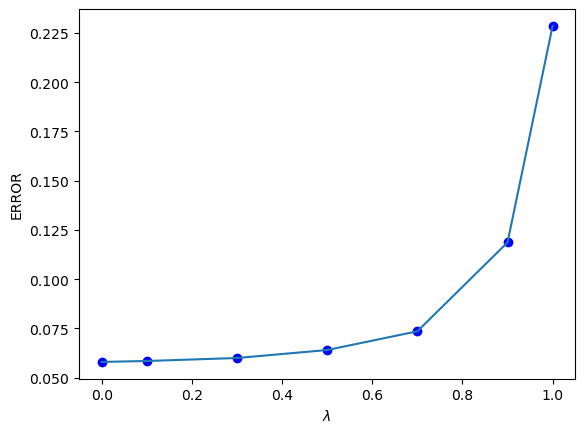

In [153]:
import matplotlib.pyplot as plt
def plot_rms_error(lambdas, data):
    rms_errors = []
    for lamb in lambdas:
        w = train(data, alpha, lamb)
        rms_errors.append(rms_error(w, P_ideal))
    plt.plot(lambdas, rms_errors)
    plt.xlabel('$\lambda$')
    plt.ylabel('ERROR')
    plt.scatter(lambdas, rms_errors, color='b')
    plt.show()

plot_rms_error(lambdas, data)


### problems/pitfalls during research
- Trouble understanding when to update $w$ and repeatedly present training sets.
- It wont fucking converge for bigger values of (especially)learning rate and convergence conditions!